## PCA based data distribution visualisation

In [1]:
from PIL import Image
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial.distance as distance
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad

In [13]:
img_dir_list = ['PIE/PIE/1/*.jpg', 'PIE/PIE/2/*.jpg', 'PIE/PIE/3/*.jpg', \
               'PIE/PIE/4/*.jpg', 'PIE/PIE/5/*.jpg', 'PIE/PIE/6/*.jpg', \
               'PIE/PIE/7/*.jpg', 'PIE/PIE/8/*.jpg', 'PIE/PIE/9/*.jpg', \
               'PIE/PIE/10/*.jpg', 'PIE/PIE/11/*.jpg', 'PIE/PIE/12/*.jpg', \
               'PIE/PIE/13/*.jpg', 'PIE/PIE/14/*.jpg', 'PIE/PIE/15/*.jpg', \
               'PIE/PIE/16/*.jpg', 'PIE/PIE/17/*.jpg', 'PIE/PIE/18/*.jpg', \
               'PIE/PIE/19/*.jpg', 'PIE/PIE/20/*.jpg']
image_list = []
image_own = []
image_list_unflattened = []
train_list = []
train_own = []
test_list = []
test_own = []
label_list = []
train_label = []
test_label = []
label_own = [20] * 10

for i in range (0, 20):
    for filename in glob.glob(img_dir_list[i]):
        im = Image.open(filename)
        arr = np.array(im).flatten()
        image_list.append(arr)
        label_list.append(i)
for filename in glob.glob('own_image/*.jpg'):
    im = Image.open(filename)
    arr = np.array(im).flatten()
    image_own.append(arr)
    
# sc = preprocessing.StandardScaler()
label_list = np.asarray(label_list)
# image_list = sc.fit_transform(image_list)
# image_own = sc.fit_transform(image_own)
image_list = np.asarray(image_list)
image_own = np.asarray(image_own)
label_own = np.asarray(label_own)

train_list, test_list, train_label, test_label = train_test_split(image_list, label_list, test_size = 0.3)
train_list = np.asarray(train_list)
test_list = np.asarray(test_list)
train_label = np.asarray(train_label)
test_label = np.asarray(test_label)

train_own, test_own, train_label_own, test_label_own = train_test_split(image_own, label_own, test_size = 0.3)
train_own = np.asarray(train_own)
test_own = np.asarray(test_own)
train_label_own = np.asarray(train_label_own)
test_label_own = np.asarray(test_label_own)

random_indices = np.arange(0, train_list.shape[0])
np.random.shuffle(random_indices)
train_sample = train_list[random_indices[:500]]
train_sample_label = train_label[random_indices[:500]]
train_sample = np.concatenate((train_sample, train_own))
train_sample_label = np.concatenate((train_sample_label, train_label_own))
test_list = np.concatenate((test_list, test_own))
test_label = np.concatenate((test_label, test_label_own))

In [14]:
train_image_mean = (np.mean(train_sample, axis = 0)).astype('float')
test_image_mean = (np.mean(test_list, axis = 0)).astype('float')
print(train_image_mean)
print(train_image_mean.shape)

[44.15581854 48.91715976 52.32741617 ... 50.93885602 52.12426036
 54.83234714]
(1024,)


In [15]:
def pca (image_list):
    image_mean = train_image_mean
    image_diff = image_list - image_mean
    image_diff = np.asarray(image_diff)
    covariance = np.cov(image_diff.T)
#     covariance = np.cov(image_list.T)
#         print(covariance.shape)
    eigenvalue, eigenvector = np.linalg.eig(covariance)
    idx = eigenvalue.argsort()[::-1]
    eigenvalue = np.real(eigenvalue[idx])
    eigenvector = np.real(eigenvector[:, idx])
    eigenvalue = np.asarray(eigenvalue)
    eigenvector = np.asarray(eigenvector)
#     eigenval_list.append(np.real(np.asarray(eigenvalue)))
#     eigenvec_list.append(np.real(np.asarray(eigenvector)))
#     eigenval_list = np.asarray(eigenval_list)
#     eigenvec_list = np.asarray(eigenvec_list)
    return eigenvalue, eigenvector

In [16]:
def get_eigen_pair(eigenvalue, eigenvector):
    eigen_pairs = [(eigenvalue[i], eigenvector[:,i]) for i in range(len(eigenvalue))]
    eigen_pairs.sort(key=lambda k: k[0], reverse = True)
    return eigen_pairs

def reduce_dim(image_list, image_mean, eigenvalue, eigenvector, dim):
    eigenpair = get_eigen_pair(eigenvalue, eigenvector)
    w = np.hstack((eigenpair[0][1][:, np.newaxis], eigenpair[1][1][:, np.newaxis]))
    if (dim > 2):
        for i in range (2, dim):
            w = np.hstack((w, eigenpair[i][1][:, np.newaxis]))
    reduce_dim_result = (image_list - image_mean).dot(w)
    return reduce_dim_result.T

In [18]:
eigenvalue_test, eigenvector_test = pca(test_list)
eigenvalue_train, eigenvector_train = pca(train_sample)
# eigenvalue_test_own, eigenvector_test_own = pca(test_own)
# eigenvalue_train_own, eigenvector_train_own = pca(train_own)

In [7]:
# w = np.hstack((test_eigenpair[0][1][:, np.newaxis], test_eigenpair[1][1][:, np.newaxis]))
# print(w.shape)
# print(reduce_dim(eigenvalue_test, eigenvector_test, 3))
# print(eigenvector_test.shape)

In [8]:
# mat = test_list.dot(w)
# plt.figure()
# plt.scatter(mat.T[0], mat.T[1])
# plt.show()

In [9]:
# print(train_list - train_image_mean)

include 35 features for 95% threshold


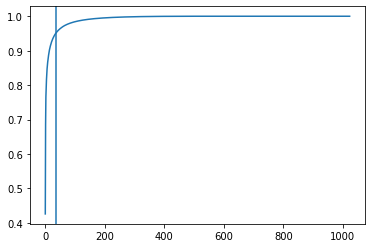

In [19]:
feature_fraction = np.cumsum(eigenvalue_train)/np.sum(eigenvalue_train)
threshold = np.argmin(np.abs(feature_fraction - 0.95))
print('include {} features for 95% threshold'.format(threshold))
plt.figure()
plt.plot(feature_fraction)
plt.axvline(threshold)
plt.show()

In [11]:
# def reduce_dim(image, eigenvector, dim):
#     image_mean = train_image_mean
#     image_diff = image - image_mean
#     image_diff = np.asarray(image_diff)
#     eigenvector_trans = eigenvector.T[:dim]
# #     print(eigenvector_trans.shape)
#     return np.dot(eigenvector_trans, image_diff.T)

In [21]:
# train_2_dim = reduce_dim(train_sample, eigenvector_train, 2)
# train_2_dim_own = reduce_dim(train_own, eigenvector_train_own, 2)
train_2_dim = reduce_dim(train_sample, train_image_mean, eigenvalue_train, eigenvector_train, 2)
# train_2_dim_own = reduce_dim(train_own, eigenvalue_train_own, eigenvector_train_own, 2)
print(train_2_dim.shape)

(2, 507)


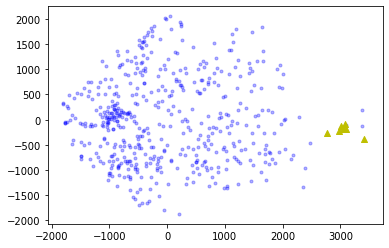

In [22]:
plt.figure()
plt.scatter(train_2_dim[0][:500], train_2_dim[1][:500], c = 'b', marker = '.', alpha = 0.3)
plt.scatter(train_2_dim[0][500:507], train_2_dim[1][500:507], c = 'y', marker = '^', alpha = 1)
plt.show()

In [24]:
train_3_dim = reduce_dim(train_sample, train_image_mean, eigenvalue_train, eigenvector_train, 3)
# train_3_dim_own = reduce_dim(train_own, eigenvector_train_own, 3)

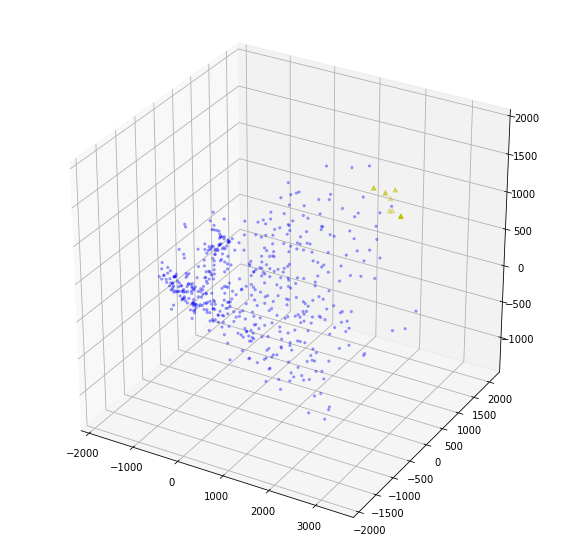

In [25]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(train_3_dim[0][:500], train_3_dim[1][:500], train_3_dim[2][:500], c = 'b', marker = '.', alpha = 0.3)
ax.scatter(train_3_dim[0][500:507], train_3_dim[1][500:507], train_3_dim[2][500:507], c = 'y', marker = '^')
plt.show()

1139777.9685387143
692095.0364936749
217217.94102597417


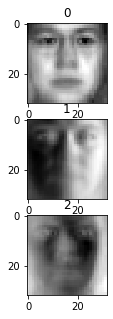

In [26]:
fig, ax = plt.subplots(3, 1, figsize = (10, 5))
for i in range (3):
    ax[i].imshow((eigenvector_train.T[i]).reshape(32, 32), cmap = 'gray')
    ax[i].set_title(i)
    print(eigenvalue_train[i])
plt.show()

In [27]:
def calc_Euclidean_dist(image_list, train_list):
    Euc_dist = np.array([[distance.euclidean(image_list[idx1], train_list[idx2]) for idx2 in np.arange(len(train_list))] for idx1 in np.arange(len(image_list))])
    return (Euc_dist)

def calc_knn_error_rate(distance, label_list, train_label_list):
    error_count = 0
    for idx, distance_1D in enumerate(distance):
        dist_idx = np.argsort(distance_1D)[:1]
        if (train_label_list[dist_idx] != label_list[idx]):
            error_count += 1
    error_rate = error_count / label_list.shape[0] * 100
    return error_rate

In [18]:
# euc_dist = calc_Euclidean_dist(test_list, train_list)
# test_knn_error_rate = calc_knn_error_rate(euc_dist, test_label, train_label)
# print(test_knn_error_rate)
# model = KNeighborsClassifier(n_neighbors = 1)
# model.fit(train_list, train_label)
# print(model.score(test_list, test_label))

In [19]:
# train_euc_dist = calc_Euclidean_dist(train_list, train_list)


In [20]:
# train_knn_error_rate = calc_knn_error_rate(train_euc_dist, train_label, train_label)
# print(train_knn_error_rate)

In [28]:
train_40_dim = reduce_dim(train_sample, train_image_mean, eigenvalue_train, eigenvector_train, 40)
train_80_dim = reduce_dim(train_sample, train_image_mean, eigenvalue_train, eigenvector_train, 80)
train_200_dim = reduce_dim(train_sample, train_image_mean, eigenvalue_train, eigenvector_train, 200)
print(train_40_dim.shape)
test_40_dim = reduce_dim(test_list, test_image_mean, eigenvalue_test, eigenvector_test, 40)
# test_40_dim_own = reduce_dim(test_own, test_image_mean, eigenvalue_test_own, eigenvector_test_own, 40)
test_80_dim = reduce_dim(test_list, test_image_mean, eigenvalue_test, eigenvector_test, 80)
# test_80_dim_own = reduce_dim(test_own, test_image_mean, eigenvalue_test_own, eigenvector_test_own, 80)
test_200_dim = reduce_dim(test_list, test_image_mean, eigenvalue_test, eigenvector_test, 200)
# test_200_dim_own = reduce_dim(test_own, eigenvalue_test_own, eigenvector_test_own, 200)

(40, 507)


In [29]:
# test_40_euc_dist = calc_Euclidean_dist(test_40_dim.T, train_40_dim.T)
# test_40_knn_error_rate = calc_knn_error_rate(test_40_euc_dist, test_label, train_sample_label)
# test_80_euc_dist = calc_Euclidean_dist(test_80_dim.T, train_80_dim.T)
# test_80_knn_error_rate = calc_knn_error_rate(test_80_euc_dist, test_label, train_sample_label)
test_200_euc_dist = calc_Euclidean_dist(test_200_dim.T, train_200_dim.T)
test_200_knn_error_rate = calc_knn_error_rate(test_200_euc_dist, test_label, train_sample_label)
# print(test_40_knn_error_rate)
# print(test_80_knn_error_rate)
print(test_200_knn_error_rate)


87.97653958944281


In [31]:
# test_40_euc_dist_own = calc_Euclidean_dist(test_40_dim_own.T, train_40_dim.T)
# test_40_knn_error_rate_own = calc_knn_error_rate(test_40_euc_dist_own, test_label_own, train_sample_label)
# test_80_euc_dist_own = calc_Euclidean_dist(test_80_dim_own.T, train_80_dim.T)
# test_80_knn_error_rate_own = calc_knn_error_rate(test_80_euc_dist_own, test_label_own, train_sample_label)
# test_200_euc_dist_own = calc_Euclidean_dist(test_200_dim_own.T, train_200_dim.T)
# test_200_knn_error_rate_own = calc_knn_error_rate(test_200_euc_dist_own, test_label_own, train_sample_label)
# print(test_40_knn_error_rate_own)
# print(test_80_knn_error_rate_own)
# print(test_200_knn_error_rate_own)


model = KNeighborsClassifier()
model.fit(train_200_dim.T, train_sample_label)
# print(model.score(test_40_dim_own.T, test_label_own))
print(model.score(train_200_dim.T, train_sample_label))

0.7297830374753451
